In [99]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

We have 3 sets of same data.
1. the original trahectory coordinates sequences
2. velocity, angles, angular velocity sequences
3. event labels sequence for pause and reversal

#### features for each event(pause, reversal, nonevent):
1. Speed Mean &rarr; SMPause, SMNonpause
2. Speed Variance &rarr; SVPasue, SVNonpause
3. Angular Speed Mean &rarr; ASMReversal, ASMNonreversal
4. Angular Speed Variance &rarr; ASVReversal, ASVNonreversal
5. Event Duration Mean &rarr; DMPause, DMNonpause, DMReversal, DMNonreversal
6. Event Duration Variance &rarr; DVPause, DVNonpause, DVReversal, DVNonreversal
7. Correlation between Speed and Angular Speed

#### features across events:
8. Pause Frequency
9. Reversal Frequency

#### other features:
10. Confinement Ratio &rarr; Sensitive to time lenght, not suitable for events since events are short

Let's start from these 10 features, we will end up with 3x8+2 features, they will be flatten into 1d vector then feed into MLP.

`Sep`: Seperate the velocity or angular velocity sequences into event(`Label=1`) or nonevent(`Label=0`) list(`PureSeq`). Each list will have different lenght of sequence. E.g. 60 steps of velocity(`DataSeq`) can be separated into `PureSeq` when `Label=1`: [[2, 3, 1], [2, 1], [5, 6]] for pause event, or `PureSeq` when `Label=0`:[[4, 5], [1, 2]] for non pause event. The two `PureSeq` merge together and reshape into 1d will be the original `DataSeq`.

In [11]:
def Sep(DataSeq, LabelSeq, Label):
    labelseq = (LabelSeq == Label).astype(int)
    PureSeq = []
    tmp = []
    for x in DataSeq*labelseq:
        if x!=0: 
            tmp.append(x)
        else:
            PureSeq.append(tmp)
            tmp = []
    if tmp!=[]:
        PureSeq.append(tmp)
    PureSeq = [x for x in PureSeq if x != []]
    return PureSeq

def SpeedMeanANDVariance(PureSeq): 
    flat=[]
    for sec in PureSeq:
        flat = flat + sec
    SM = np.mean(np.array(flat))
    SV = np.var(np.array(flat))
    return SM, SV

def DurMeanANDVariance(PureSeq): 
    dur=[]
    for sec in PureSeq:
        dur.append(len(sec))
    DM = sum(dur)/len(dur)
    DV = np.var(np.array(dur))
    return DM, DV

def ConfinementRatio(CoorSeq):
    d_total = 0
    for i in range(1, len(CoorSeq)):
        d_total += math.sqrt(math.pow((CoorSeq[i][0]-CoorSeq[i-1][0]), 2)+math.pow((CoorSeq[i][1]-CoorSeq[i-1][1]), 2))
    d_net = math.sqrt(math.pow((CoorSeq[-1][0]-CoorSeq[0][0]), 2)+math.pow((CoorSeq[-1][1]-CoorSeq[0][1]), 2))
    return d_net/d_total

In [79]:
def FinalFeature(sample_coor_vav_event):
    CoorSeq = sample_coor_vav_event[:, :2]
    DataSeq_V = sample_coor_vav_event[:, 4]
    DataSeq_Av = sample_coor_vav_event[:, 5]
    LabelSeq_Pause = sample_coor_vav_event[:, 6]
    LabelSeq_Reversal = sample_coor_vav_event[:, 7]
        
    if not LabelSeq_Pause.any():# 10 pause-based features
        speed_mean_pause= 0
        speed_var_pause = 0
        speed_mean_npause = 0
        speed_var_npause = 0
        dur_mean_pause = 0 
        dur_var_pause = 0
        dur_mean_npause = 0
        dur_var_npause = 0
        freq_pause = 0
        ratio_pause = 0
    else:
        PureSeq_Pause = Sep(DataSeq_V, LabelSeq_Pause, 1)
        PureSeq_Npause = Sep(DataSeq_V, LabelSeq_Pause, 0)
        speed_mean_pause,speed_var_pause = SpeedMeanANDVariance(PureSeq_Pause)
        speed_mean_npause,speed_var_npause = SpeedMeanANDVariance(PureSeq_Npause)
        dur_mean_pause, dur_var_pause = DurMeanANDVariance(PureSeq_Pause)
        dur_mean_npause, dur_var_npause = DurMeanANDVariance(PureSeq_Npause)
        freq_pause = len(PureSeq_Pause)/2
        ratio_pause = sum(LabelSeq_Pause)/len(LabelSeq_Pause)
        
    if not LabelSeq_Reversal.any(): # 10 reversal-based features
        aspeed_mean_reversal = 0
        aspeed_var_reversal = 0
        aspeed_mean_nreversal = 0
        aspeed_var_nreversal = 0
        dur_mean_reversal = 0
        dur_var_reversal = 0
        dur_mean_nreversal = 0
        dur_var_nreversal = 0
        freq_reversal = 0
        ratio_reversal = 0
    else:
        PureSeq_Reversal = Sep(DataSeq_Av, LabelSeq_Reversal, 1)
        PureSeq_Nreversal = Sep(DataSeq_Av, LabelSeq_Reversal, 0)
        aspeed_mean_reversal,aspeed_var_reversal = SpeedMeanANDVariance(PureSeq_Reversal)
        aspeed_mean_nreversal,aspeed_var_nreversal = SpeedMeanANDVariance(PureSeq_Nreversal)
        dur_mean_reversal, dur_var_reversal = DurMeanANDVariance(PureSeq_Reversal)
        dur_mean_nreversal, dur_var_nreversal = DurMeanANDVariance(PureSeq_Nreversal)
        freq_reversal = len(PureSeq_Reversal)/2
        ratio_reversal = sum(LabelSeq_Reversal)/len(LabelSeq_Reversal)
        
    # 6 general features:
    speed_mean_all = np.mean(DataSeq_V)
    speed_var_all = np.var(DataSeq_V)
    aspeed_mean_all = np.mean(DataSeq_Av)
    aspeed_var_all = np.var(DataSeq_Av)
    vaa_corr = np.correlate(DataSeq_V, DataSeq_Av)
    ConfineRatio = ConfinementRatio(CoorSeq)   

    ff = np.array([# 10 pause features
                   speed_mean_pause, speed_var_pause, speed_mean_npause, speed_var_npause, dur_mean_pause, 
                   dur_var_pause, dur_mean_npause, dur_var_npause, freq_pause, ratio_pause,
                   # 10 reversal features
                   aspeed_mean_reversal, aspeed_var_reversal, aspeed_mean_nreversal, aspeed_var_nreversal, dur_mean_reversal,
                   dur_var_reversal, dur_mean_nreversal, dur_var_nreversal, freq_reversal, ratio_reversal,
                   # 6 general features
                   speed_mean_all, speed_var_all, aspeed_mean_all, aspeed_var_all, vaa_corr, ConfineRatio
                  ])
    return ff

In [80]:
classname_list = os.listdir(os.path.join("npy", "3xyang3angvav2event"))
for classfile in classname_list:
    classfile_path = os.path.join("npy", "3xyang3angvav2event",classfile)
    class_3xyang3angvav2event = np.load(classfile_path)
    ff_class=[]
    for i in range(class_3xyang3angvav2event.shape[0]):
        ff_class.append(FinalFeature(class_3xyang3angvav2event[i]))
    ff_class = np.array(ff_class)
    file_name = classfile[:-9]+"26features.npy"
    file_path = os.path.join("npy", "26feature", file_name)
    np.save(file_path, ff_class)
    print(classfile[:-10], ":")
    df = pd.DataFrame(ff_class)
    display(df.head())

class0_A1_844 :


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,2.259590,0.048463,5.665427,2.057182,3.0,0.0,28.5,2.25,0.5,0.050000,...,22.0,441.0,0.5,0.266667,5.495135,2.507733,0.033457,0.038734,9.737470,0.882993
1,1.161944,0.144940,3.576805,1.302530,2.0,0.0,29.0,289.00,0.5,0.033333,...,25.0,441.0,1.0,0.166667,3.496310,1.451850,0.045169,0.025143,7.661313,0.917395
2,1.793389,0.104629,4.118687,1.111823,2.0,0.0,29.0,144.00,0.5,0.033333,...,0.0,0.0,0.0,0.000000,4.041177,1.252476,0.010125,0.023033,3.236157,0.986758
3,1.836401,0.025696,3.597850,0.709831,2.0,0.0,29.0,1.00,0.5,0.033333,...,0.0,0.0,0.0,0.000000,3.539135,0.787003,0.011756,0.016167,2.922854,0.982891
4,1.746909,0.046949,4.007838,1.308480,2.0,0.0,29.0,49.00,0.5,0.033333,...,0.0,0.0,0.0,0.000000,3.932473,1.431142,-0.007346,0.020544,-2.098096,0.957395


class1_A4_1029 :


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.780709,0.174736,4.945839,2.051498,2.0,0.0,29.0,529.0,0.5,0.033333,...,0.000000,0.000000,0.0,0.000000,4.840335,2.311743,-0.002583,0.009316,-1.720907,0.987762
1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,5.212518,1.519013,0.007888,0.011368,1.183919,0.968481
2,1.405868,0.567124,6.086869,1.748326,2.0,0.0,29.0,4.0,0.5,0.033333,...,0.000000,0.000000,0.0,0.000000,5.930836,2.414998,0.002011,0.009799,1.181989,0.981717
3,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,4.851812,1.404019,0.008475,0.014688,0.983301,0.963543
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,17.666667,522.888889,1.0,0.116667,4.322525,2.187367,-0.005197,0.012965,-1.965451,0.949803


class2_S7_1317 :


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,2.036573,0.606380,8.172653,6.411354,2.0,0.00,18.666667,182.888889,1.0,0.066667,...,27.5,156.25,0.5,0.083333,7.763581,8.367114,0.046670,0.158950,7.052344,0.300448
1,2.208200,1.384476,6.222345,5.109238,3.5,2.25,17.666667,348.222222,1.0,0.116667,...,10.0,91.50,1.5,0.333333,5.754028,6.335254,-0.093591,0.169722,-6.968554,0.963595
2,1.262408,0.517288,4.252046,1.491395,3.5,2.25,26.500000,12.250000,1.0,0.116667,...,26.0,625.00,0.5,0.133333,3.903255,2.298853,0.005762,0.123515,1.344719,0.988741
3,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.000000,...,0.0,0.00,0.0,0.000000,7.762665,2.867102,0.005204,0.007954,1.086600,0.994958
4,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.000000,...,28.5,756.25,0.5,0.050000,3.600479,1.830521,-0.010209,0.092460,0.319821,0.927873


class3_Y1_1098 :


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0000,0.0,0.000000,5.969917,1.825049,-0.001447,0.003989,0.569625,0.987948
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.50,650.2500,1.0,0.116667,4.543397,1.652288,0.010801,0.033898,2.101896,0.979989
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0000,0.0,0.000000,5.899132,1.581894,0.009109,0.004603,3.880868,0.991558
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.75,212.6875,2.0,0.350000,5.748531,2.420764,0.005164,0.003535,2.578343,0.996087
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0000,0.0,0.000000,4.861657,1.386564,-0.007397,0.008109,-2.247879,0.985734


class4_Y4_1029 :


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.526462,0.157060,3.465060,1.722434,3.0,0.00,18.000000,172.666667,1.0,0.100000,...,28.0,729.00,0.5,0.066667,3.271200,1.904132,-0.048675,0.079305,-7.191543,0.957577
1,1.490670,0.027070,3.391241,1.238911,4.5,6.25,17.000000,78.000000,1.0,0.150000,...,0.0,0.00,0.0,0.000000,3.106156,1.517687,-0.020089,0.033600,-3.118210,0.955673
2,1.987859,0.327023,7.348149,5.431281,2.5,0.25,18.333333,0.888889,1.0,0.083333,...,0.0,0.00,0.0,0.000000,6.901458,7.200785,-0.011120,0.005400,-2.174015,0.991720
3,2.080678,0.195445,4.291575,1.175218,2.0,0.00,29.000000,16.000000,0.5,0.033333,...,0.0,0.00,0.0,0.000000,4.217878,1.300063,0.006524,0.012291,3.123497,0.929411
4,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.000000,...,9.5,29.25,1.5,0.366667,7.829380,2.267050,0.016737,0.002857,8.955852,0.980221


In [81]:
file_list = os.listdir(os.path.join("npy", "26feature"))
x_total = []
y_total = []
for i in range(len(file_list)):
    x_class = np.load(os.path.join("npy","26feature", file_list[i]))
    class_n = int(file_list[i][5])
    for n in range(x_class.shape[0]):
        x_total.append(x_class[n])
        y_total.append(class_n)
x_total = np.array(x_total)
y_total = np.array(y_total)
print("total sample size x:", x_total.shape)
print("total sample size y:", y_total.shape)
filex_path = os.path.join("npy", "26feature", "x_total.npy")
filey_path = os.path.join("npy", "26feature", "y_total.npy")
np.save(filex_path, x_total)
np.save(filey_path, y_total)

total sample size x: (5317, 26)
total sample size y: (5317,)


In [57]:
para_names = [# 10 pauuse features
              'speed_mean_pause', 'speed_var_pause', 'speed_mean_npause', 'speed_var_npause', 'dur_mean_pause', 
              'dur_var_pause', 'dur_mean_npause', 'dur_var_npause', 'freq_pause', 'ratio_pause',
              # 10 reversal features
              'aspeed_mean_reversal', 'aspeed_var_reversal', 'aspeed_mean_nreversal', 'aspeed_var_nreversal', 'dur_mean_reversal',
              'dur_var_reversal', 'dur_mean_nreversal', 'dur_var_nreversal', 'freq_reversal', 'ratio_reversal',
              # 6 general features
              'speed_mean_all', 'speed_var_all', 'aspeed_mean_all', 'aspeed_var_all', 'vaa_corr', 'ConfineRatio'
             ]
for i in range(len(para_names)):
    print(i, para_names[i])
    

0 speed_mean_pause
1 speed_var_pause
2 speed_mean_npause
3 speed_var_npause
4 dur_mean_pause
5 dur_var_pause
6 dur_mean_npause
7 dur_var_npause
8 freq_pause
9 ratio_pause
10 aspeed_mean_reversal
11 aspeed_var_reversal
12 aspeed_mean_nreversal
13 aspeed_var_nreversal
14 dur_mean_reversal
15 dur_var_reversal
16 dur_mean_nreversal
17 dur_var_nreversal
18 freq_reversal
19 ratio_reversal
20 speed_mean_all
21 speed_var_all
22 aspeed_mean_all
23 aspeed_var_all
24 vaa_corr
25 ConfineRatio


In [82]:
x_total = np.load(os.path.join("npy","26feature", "x_total.npy"))
y_total = np.load(os.path.join("npy","26feature", "y_total.npy"))
for i in range(len(para_names)):
    fx = x_total[:,i]
    file_name = "feature"+str(i)+"_"+para_names[i]+".npy"
    file_path = os.path.join("npy", "26feature", "single", file_name)
    print(file_path)
    np.save(file_path, fx)

npy\26feature\single\feature0_speed_mean_pause.npy
npy\26feature\single\feature1_speed_var_pause.npy
npy\26feature\single\feature2_speed_mean_npause.npy
npy\26feature\single\feature3_speed_var_npause.npy
npy\26feature\single\feature4_dur_mean_pause.npy
npy\26feature\single\feature5_dur_var_pause.npy
npy\26feature\single\feature6_dur_mean_npause.npy
npy\26feature\single\feature7_dur_var_npause.npy
npy\26feature\single\feature8_freq_pause.npy
npy\26feature\single\feature9_ratio_pause.npy
npy\26feature\single\feature10_aspeed_mean_reversal.npy
npy\26feature\single\feature11_aspeed_var_reversal.npy
npy\26feature\single\feature12_aspeed_mean_nreversal.npy
npy\26feature\single\feature13_aspeed_var_nreversal.npy
npy\26feature\single\feature14_dur_mean_reversal.npy
npy\26feature\single\feature15_dur_var_reversal.npy
npy\26feature\single\feature16_dur_mean_nreversal.npy
npy\26feature\single\feature17_dur_var_nreversal.npy
npy\26feature\single\feature18_freq_reversal.npy
npy\26feature\single\fea

There are 4 situations for sample:
    1. doesn't have pause nor reversal
    2. have pause but not reversal
    3. have reversal but not pause
    4. have both reversal and pause

#### Plot the distributions of 26 features for each class

In [ ]:
def classDF(class_n):
    x_total = np.load(os.path.join("npy","26feature", "x_total.npy"))
    y_total = np.load(os.path.join("npy","26feature", "y_total.npy"))
    class_idx = list(np.where(y_total==class_n)[0])
    df_pause = pd.DataFrame(x_total[class_idx, :10])
    df_pause.columns = para_names[:10]
    df_reversal = pd.DataFrame(x_total[class_idx, 10:20])
    df_reversal.columns = para_names[10:20]
    df_general = pd.DataFrame(x_total[class_idx, 20:])
    df_general.columns = para_names[20:]
        
    return df_pause, df_reversal, df_general

def PlotPair(df_pause, df_reversal, df_general):
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.pairplot(df_pause)

    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.pairplot(df_reversal)
    
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.pairplot(df_general)

In [392]:
def featureList(feature_n):
    x_total = np.load(os.path.join("npy","26feature", "x_total.npy"))
    y_total = np.load(os.path.join("npy","26feature", "y_total.npy"))
    class0_idx = list(np.where(y_total==0)[0])
    class1_idx = list(np.where(y_total==1)[0])
    class2_idx = list(np.where(y_total==2)[0])
    class3_idx = list(np.where(y_total==3)[0])
    class4_idx = list(np.where(y_total==4)[0])
    
    feature_list = []
    feature_list.append(list(x_total[class0_idx, feature_n]))
    feature_list.append(list(x_total[class1_idx, feature_n]))
    feature_list.append(list(x_total[class2_idx, feature_n]))
    feature_list.append(list(x_total[class3_idx, feature_n]))
    feature_list.append(list(x_total[class4_idx, feature_n]))

    return feature_list

def featureListEvent(feature_n): #feauture_n < 20
    x_total = np.load(os.path.join("npy","26feature", "x_total.npy"))
    y_total = np.load(os.path.join("npy","26feature", "y_total.npy"))
    if feature_n<10: # Pause
        idx_event_all = []
        for i in range(5):
            class_idx = list(np.where(y_total==i)[0])
            class_idx_pause = []
            for i in range(len(class_idx)):
                if x_total[class_idx[i],:10].all():
                    class_idx_pause.append(x_total[class_idx[i],feature_n])
            idx_event_all.append(class_idx_pause)
    else: #Reversal
        idx_event_all = []
        for i in range(5):
            class_idx = list(np.where(y_total==i)[0])
            class_idx_reversal = []
            for i in range(len(class_idx)):
                if x_total[class_idx[i],10:20].any():
                    class_idx_reversal.append(x_total[class_idx[i], feature_n])
            idx_event_all.append(class_idx_reversal)
    return idx_event_all
    
def PlotFeatureBox(feature_n): # Input is a list of length 5
    para_names = ['speed_mean_pause', 'speed_var_pause', 'speed_mean_npause', 'speed_var_npause', 'dur_mean_pause', 
                  'dur_var_pause', 'dur_mean_npause', 'dur_var_npause', 'freq_pause', 'ratio_pause',
                  'aspeed_mean_reversal', 'aspeed_var_reversal', 'aspeed_mean_nreversal', 'aspeed_var_nreversal', 'dur_mean_reversal',
                  'dur_var_reversal', 'dur_mean_nreversal', 'dur_var_nreversal', 'freq_reversal', 'ratio_reversal',
                  'speed_mean_all', 'speed_var_all', 'aspeed_mean_all', 'aspeed_var_all', 'vaa_corr', 'ConfineRatio']
    l = featureList(feature_n)
    plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    plt.boxplot(l, sym='rD')
    #l_flat = [item for sublist in l for item in sublist]
    plt.xticks([1, 2, 3, 4, 5], ['A1', 'A4', 'Sp7', 'Y1', 'Y4'])
    plt.ylabel(para_names[feature_n])
    plt.title('All trajectories included')
    
    if feature_n<20:
        l = featureListEvent(feature_n)
        plt.subplot(122)
        plt.boxplot(l, sym='rD')
        plt.xticks([1, 2, 3, 4, 5], ['A1', 'A4', 'Sp7', 'Y1', 'Y4'])
        plt.ylabel(para_names[feature_n])
        if feature_n<10:
            plt.title('Pause trajectories exclusive')
        else:
            plt.title('Reversal trajectories exclusive')
    
    plt.subplots_adjust(bottom=0.3, wspace=0.3)
    file_name = para_names[feature_n] + '_box.png'
    file_path = os.path.join("plot", file_name)
    plt.savefig(file_path)
    plt.show()

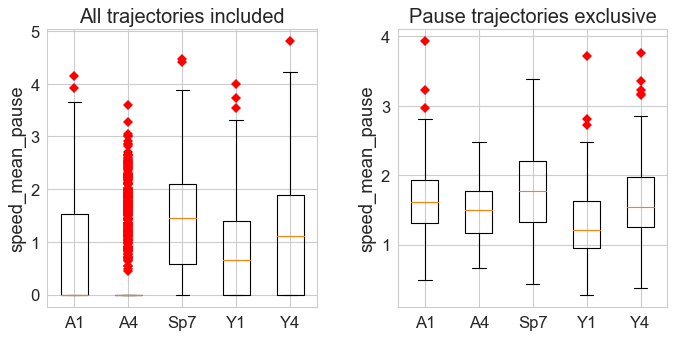

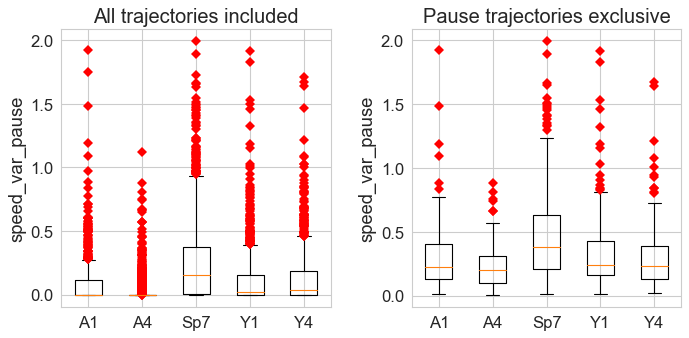

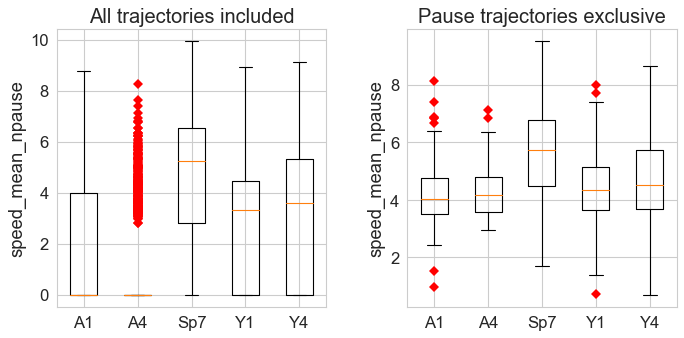

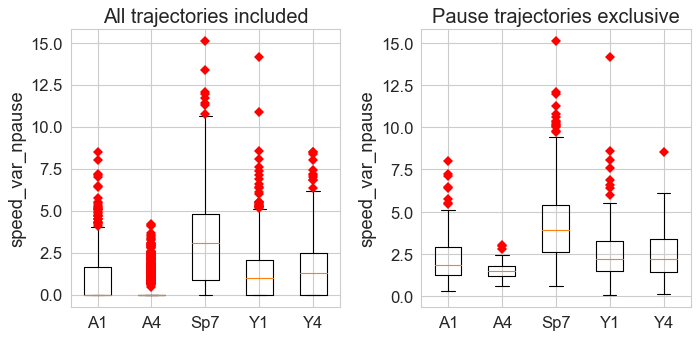

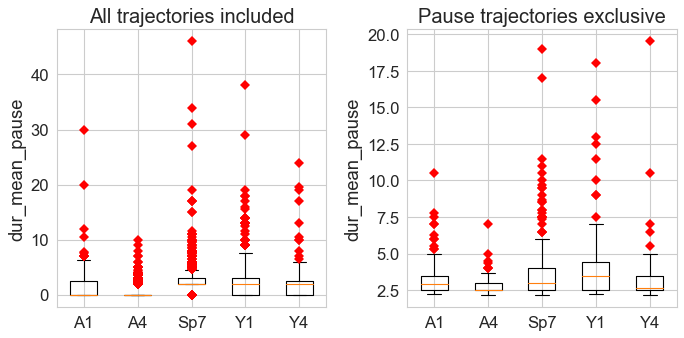

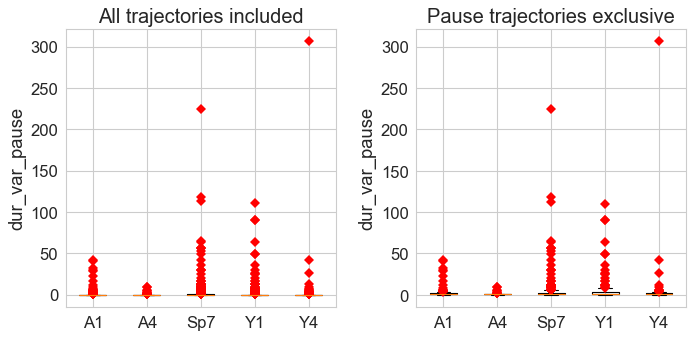

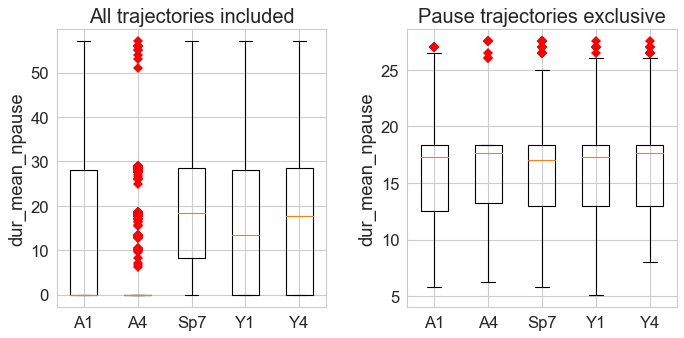

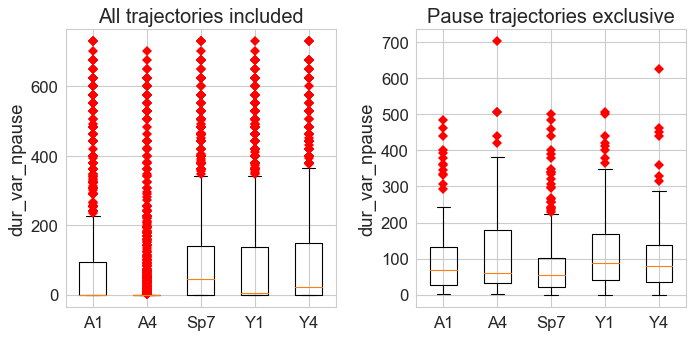

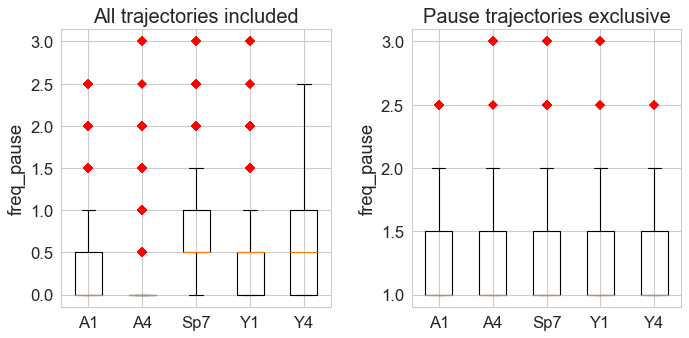

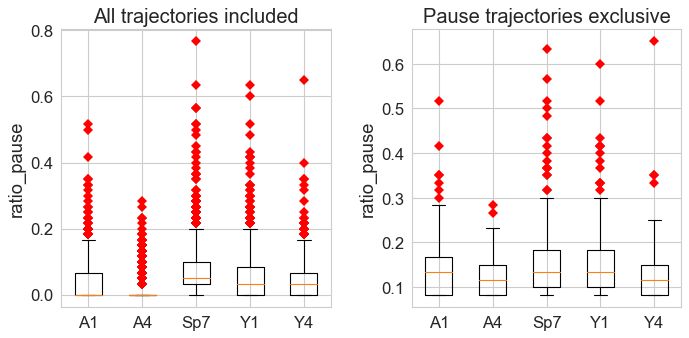

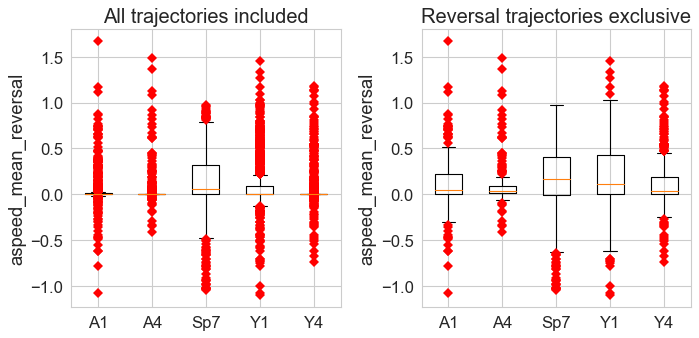

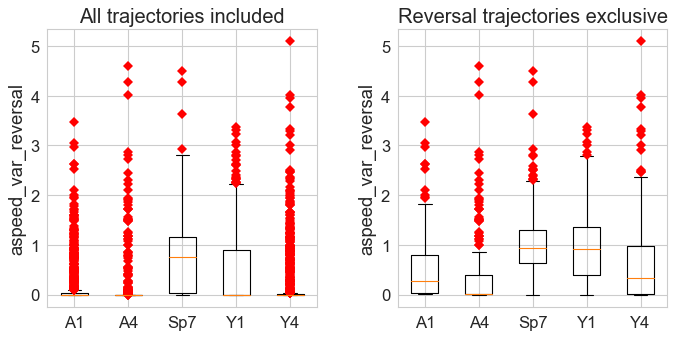

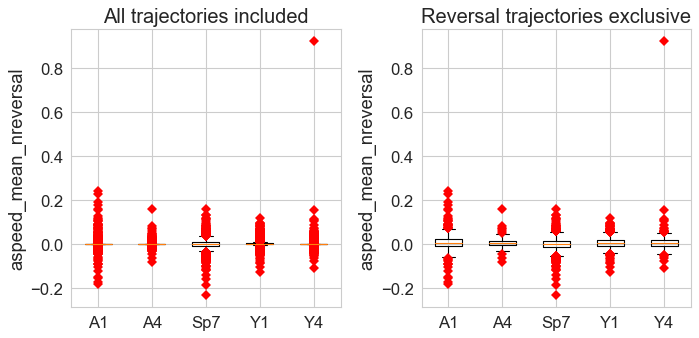

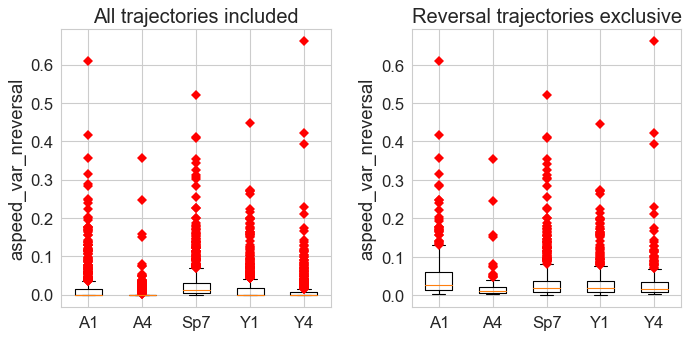

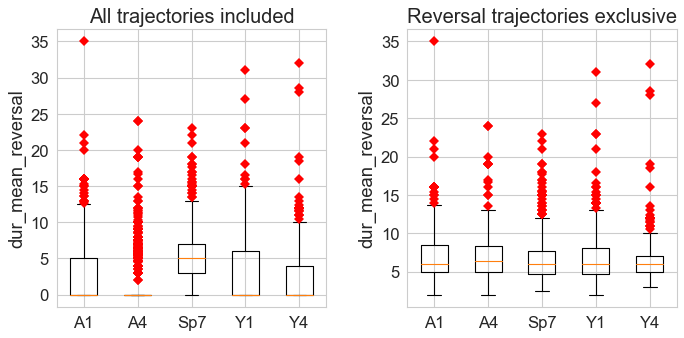

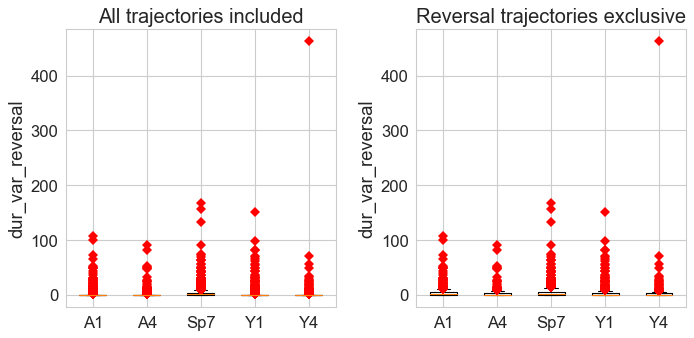

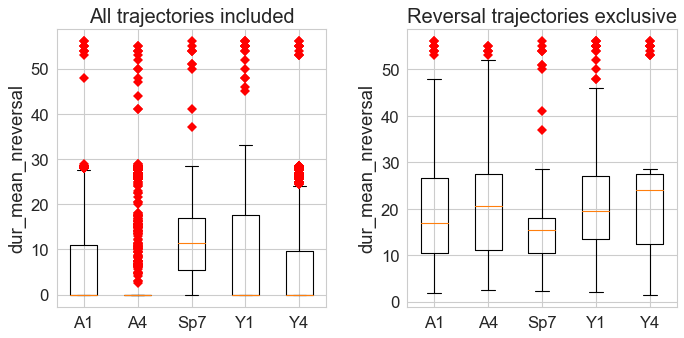

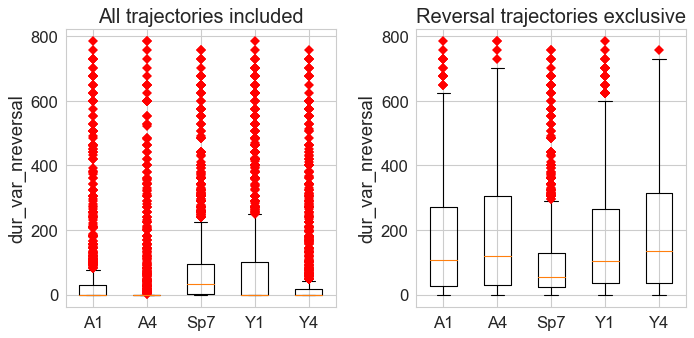

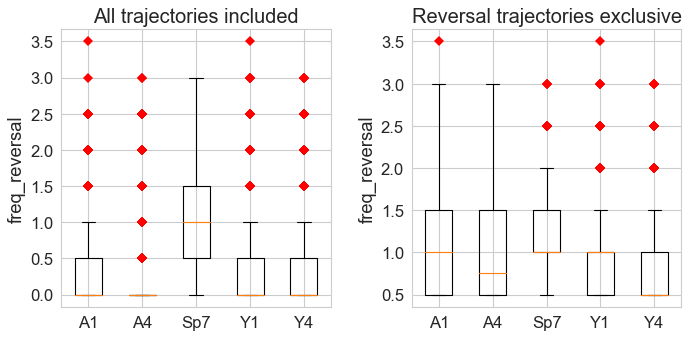

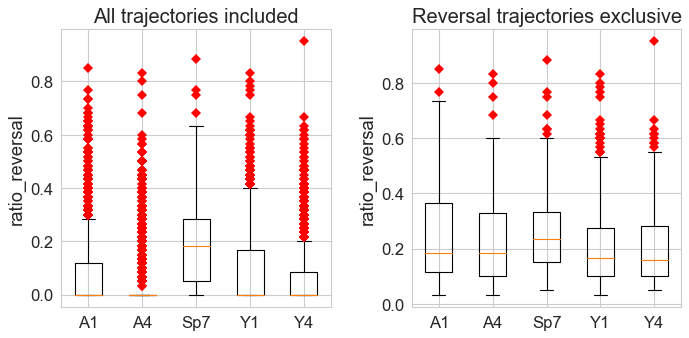

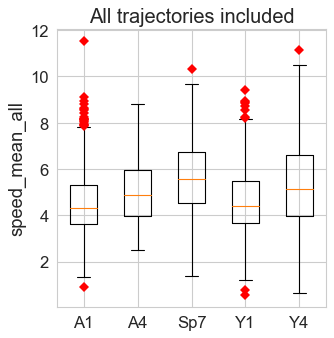

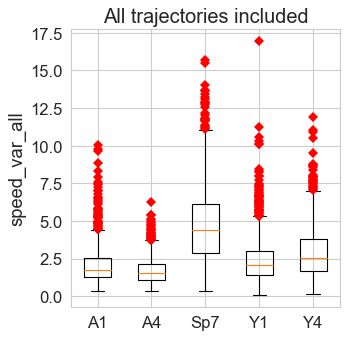

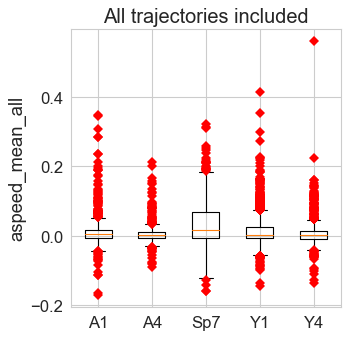

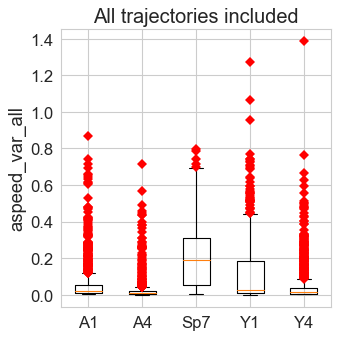

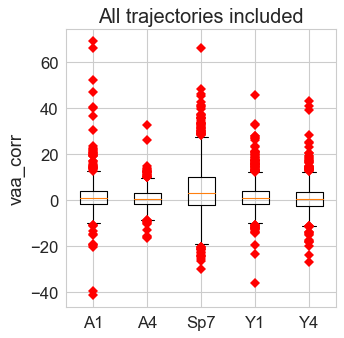

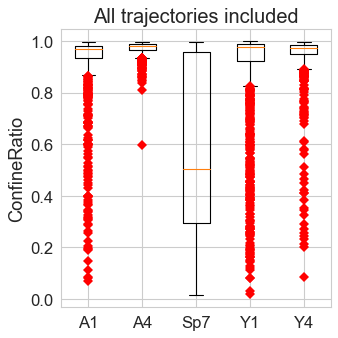

In [393]:
for i in range(26):
    PlotFeatureBox(i)

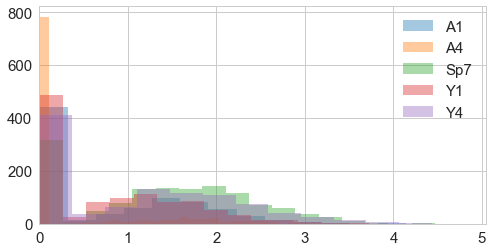

In [385]:
l = featureList(0)
plt.figure(num=None, figsize=(8, 4))
sns.distplot(l[0], kde=False, label='A1')
sns.distplot(l[1], kde=False, label='A4')
sns.distplot(l[2], kde=False, label='Sp7')
sns.distplot(l[3], kde=False, label='Y1')
sns.distplot(l[4], kde=False, label='Y4')
plt.legend()
plt.xlim(0,None)
plt.show()

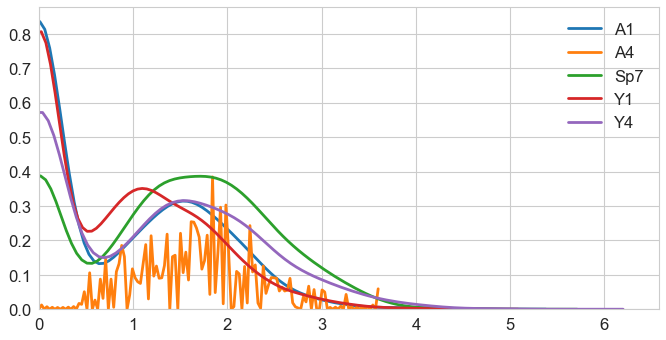

In [387]:
l = featureList(0)
plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
sns.kdeplot(l[0], cut=5, label='A1')
sns.kdeplot(l[1], cut=5, label='A4')
sns.kdeplot(l[2], cut=5, label='Sp7')
sns.kdeplot(l[3], cut=5, label='Y1')
sns.kdeplot(l[4], cut=5, label='Y4')
plt.legend()
plt.xlim(0,None)
plt.show()

In [394]:
def PlotFeatureCurve(feature_n): # Input is a list of length 5
    para_names = ['speed_mean_pause', 'speed_var_pause', 'speed_mean_npause', 'speed_var_npause', 'dur_mean_pause', 
                  'dur_var_pause', 'dur_mean_npause', 'dur_var_npause', 'freq_pause', 'ratio_pause',
                  'aspeed_mean_reversal', 'aspeed_var_reversal', 'aspeed_mean_nreversal', 'aspeed_var_nreversal', 'dur_mean_reversal',
                  'dur_var_reversal', 'dur_mean_nreversal', 'dur_var_nreversal', 'freq_reversal', 'ratio_reversal',
                  'speed_mean_all', 'speed_var_all', 'aspeed_mean_all', 'aspeed_var_all', 'vaa_corr', 'ConfineRatio']
    l = featureList(feature_n)
    plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    l = featureList(0)
    sns.kdeplot(l[0], cut=5, label='A1')
    sns.kdeplot(l[1], cut=5, label='A4')
    sns.kdeplot(l[2], cut=5, label='Sp7')
    sns.kdeplot(l[3], cut=5, label='Y1')
    sns.kdeplot(l[4], cut=5, label='Y4')
    neg_f = [10, 12, 22, 24]
    if feature_n not in neg_f:
        plt.xlim(0,None)
    plt.legend()
    plt.title('All trajectories included')
    
    if feature_n<20:
        l = featureListEvent(feature_n)
        plt.subplot(122)
        sns.kdeplot(l[0], cut=5, label='A1')
        sns.kdeplot(l[1], cut=5, label='A4')
        sns.kdeplot(l[2], cut=5, label='Sp7')
        sns.kdeplot(l[3], cut=5, label='Y1')
        sns.kdeplot(l[4], cut=5, label='Y4')
        neg_f = [10, 12, 22, 24]
        if feature_n not in neg_f:
            plt.xlim(0,None)
        if feature_n<10:
            plt.title('Pause trajectories exclusive')
        else:
            plt.title('Reversal trajectories exclusive')
    
    plt.subplots_adjust(bottom=0.3, wspace=0.3)
    file_name = para_names[feature_n] + '_curve.png'
    file_path = os.path.join("plot", file_name)
    plt.savefig(file_path)
    plt.show()

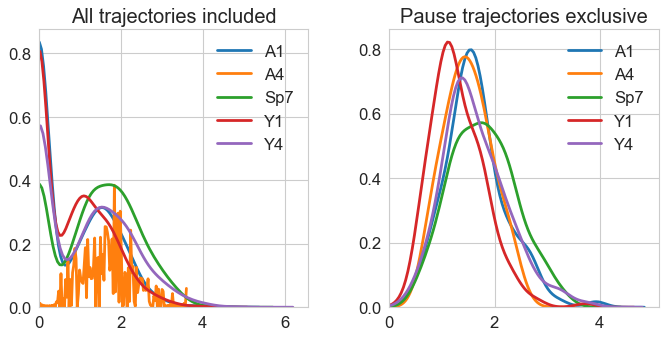

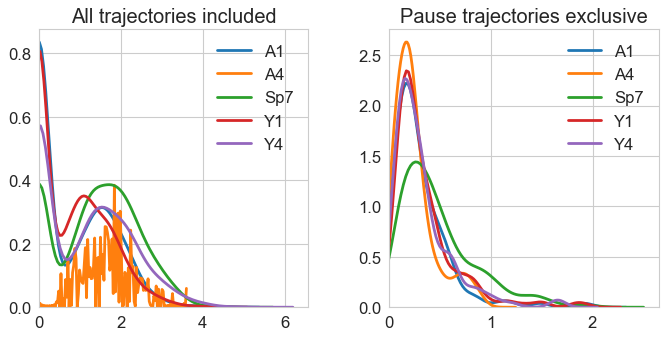

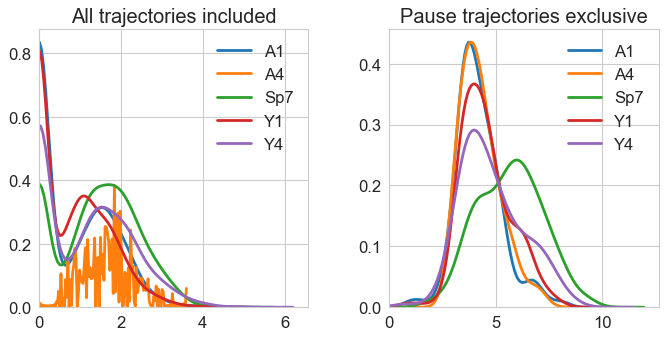

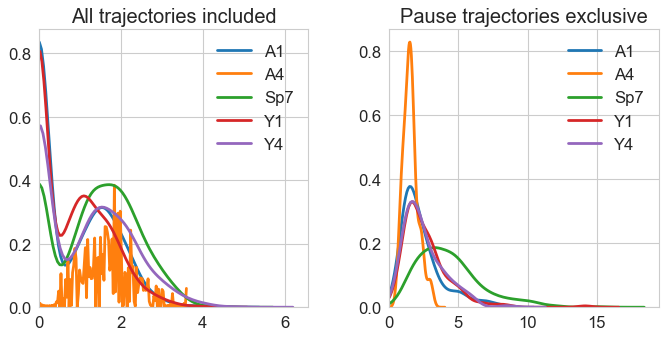

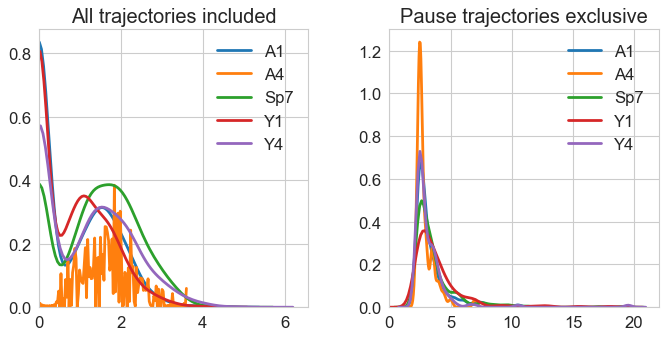

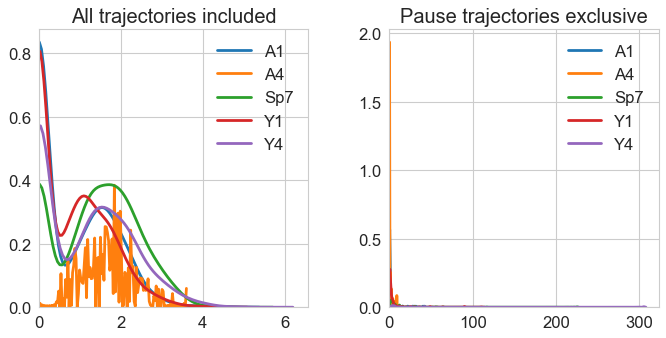

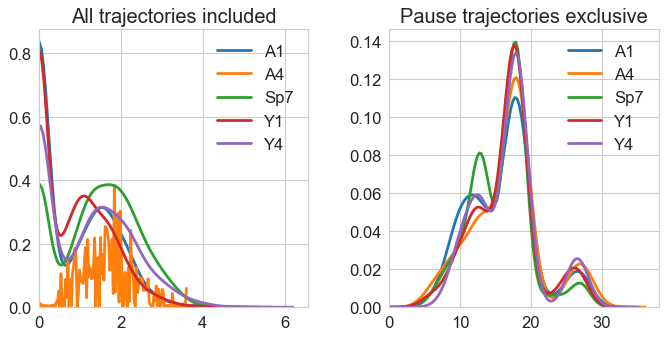

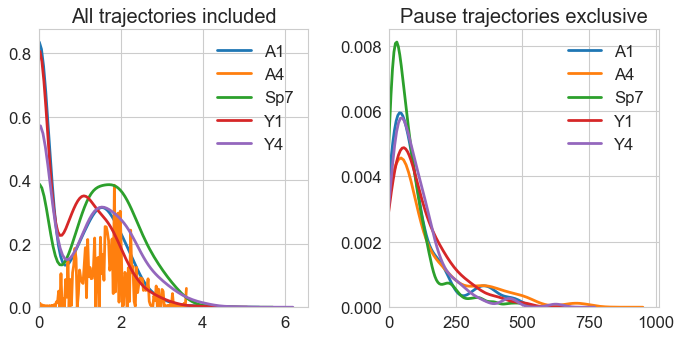

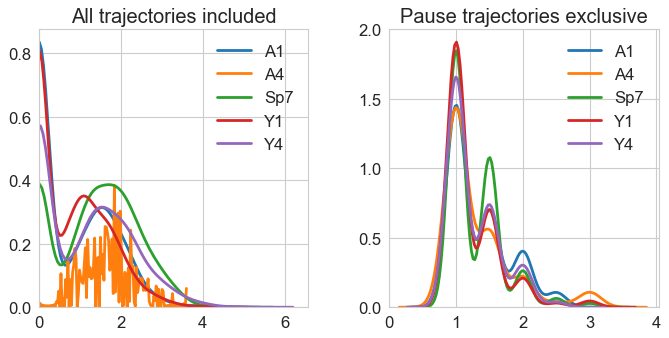

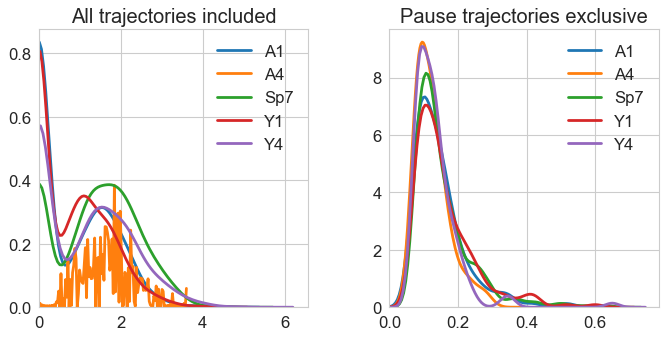

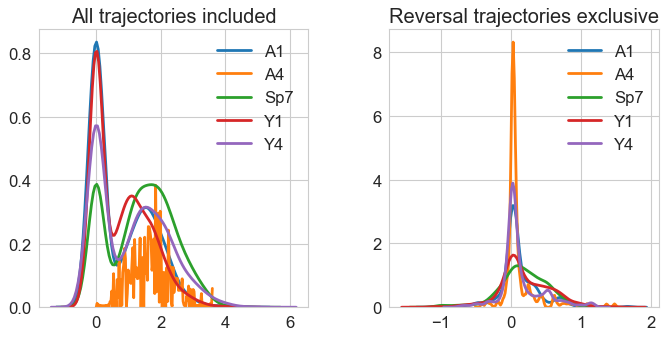

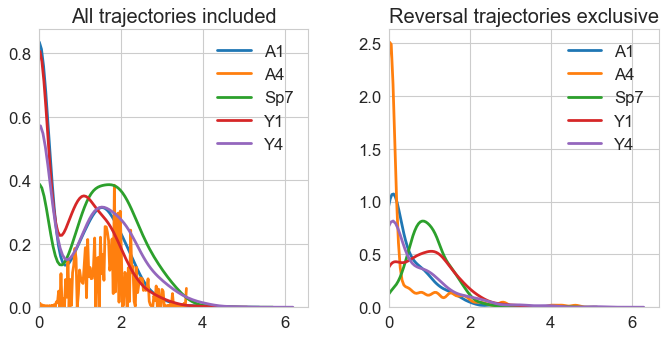

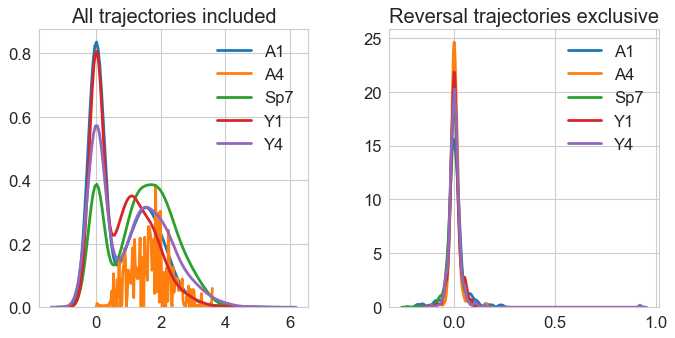

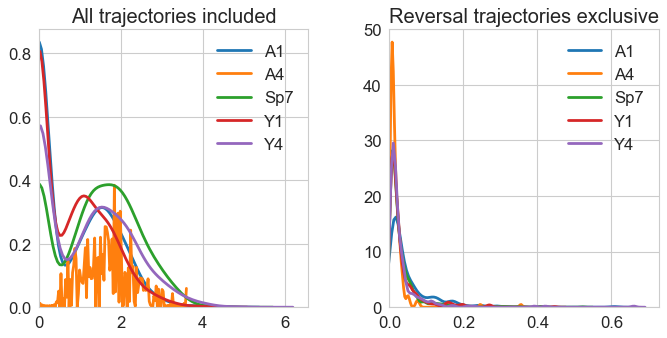

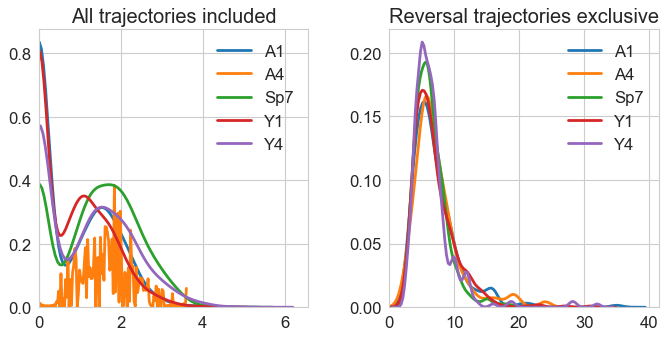

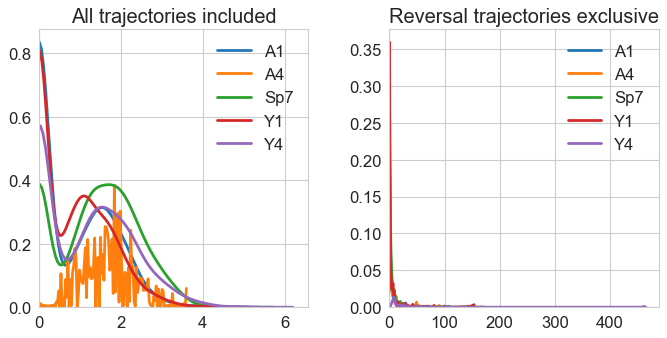

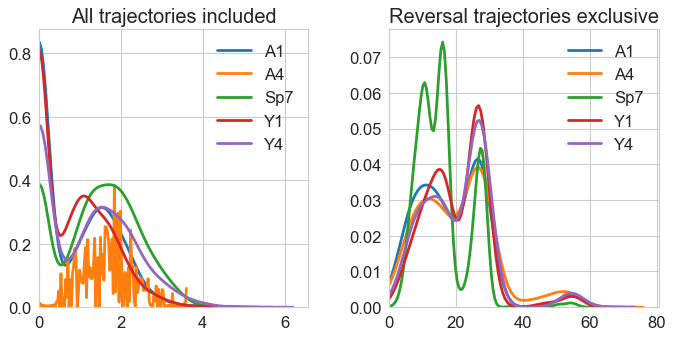

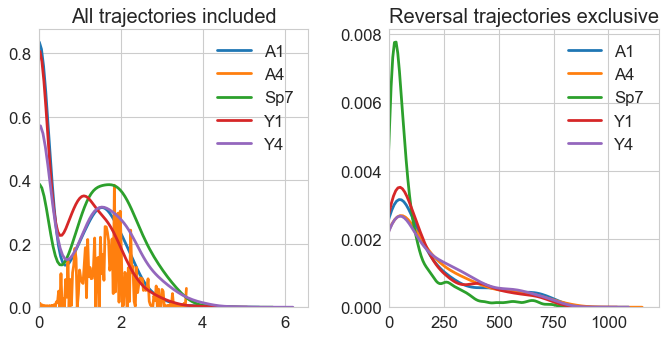

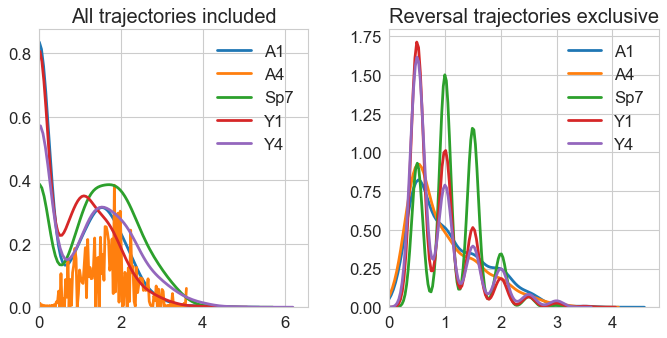

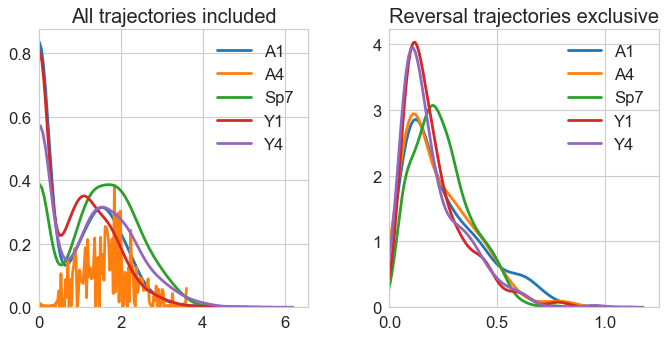

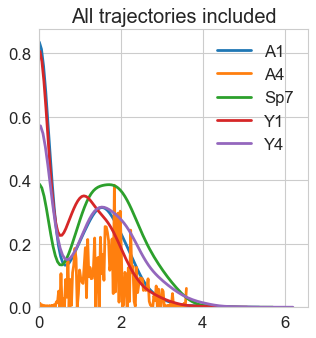

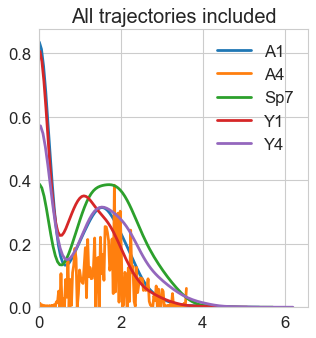

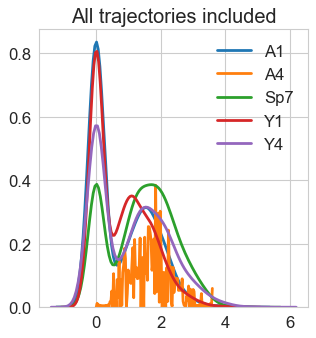

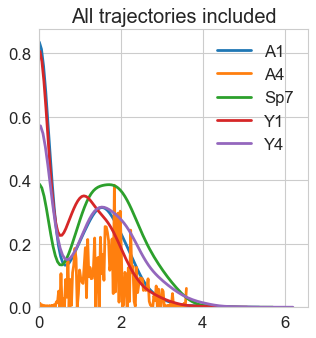

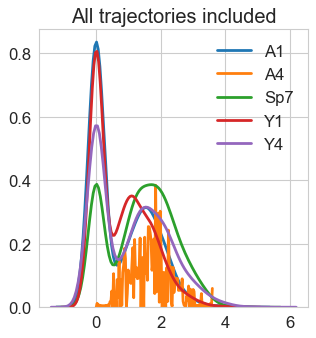

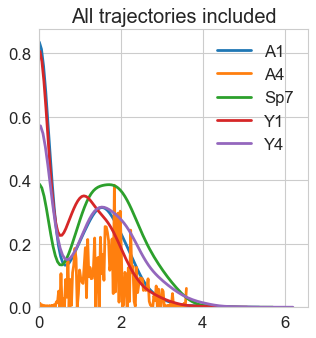

In [395]:
for i in range(26):
    PlotFeatureCurve(i)

In [397]:
def PlotFeatureHist(feature_n): # Input is a list of length 5
    para_names = ['speed_mean_pause', 'speed_var_pause', 'speed_mean_npause', 'speed_var_npause', 'dur_mean_pause', 
                  'dur_var_pause', 'dur_mean_npause', 'dur_var_npause', 'freq_pause', 'ratio_pause',
                  'aspeed_mean_reversal', 'aspeed_var_reversal', 'aspeed_mean_nreversal', 'aspeed_var_nreversal', 'dur_mean_reversal',
                  'dur_var_reversal', 'dur_mean_nreversal', 'dur_var_nreversal', 'freq_reversal', 'ratio_reversal',
                  'speed_mean_all', 'speed_var_all', 'aspeed_mean_all', 'aspeed_var_all', 'vaa_corr', 'ConfineRatio']
    l = featureList(feature_n)
    plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    l = featureList(0)
    sns.distplot(l[0], kde=False, label='A1')
    sns.distplot(l[1], kde=False, label='A4')
    sns.distplot(l[2], kde=False, label='Sp7')
    sns.distplot(l[3], kde=False, label='Y1')
    sns.distplot(l[4], kde=False, label='Y4')
    neg_f = [10, 12, 22, 24]
    if feature_n not in neg_f:
        plt.xlim(0,None)
    plt.legend()
    plt.title('All trajectories included')
    
    if feature_n<20:
        l = featureListEvent(feature_n)
        plt.subplot(122)
        sns.distplot(l[0], kde=False, label='A1')
        sns.distplot(l[1], kde=False, label='A4')
        sns.distplot(l[2], kde=False, label='Sp7')
        sns.distplot(l[3], kde=False, label='Y1')
        sns.distplot(l[4], kde=False, label='Y4')
        neg_f = [10, 12, 22, 24]
        if feature_n not in neg_f:
            plt.xlim(0,None)
        if feature_n<10:
            plt.title('Pause trajectories exclusive')
        else:
            plt.title('Reversal trajectories exclusive')
    
    plt.subplots_adjust(bottom=0.3, wspace=0.3)
    file_name = para_names[feature_n] + '_curve.png'
    file_path = os.path.join("plot", file_name)
    plt.savefig(file_path)
    plt.show()

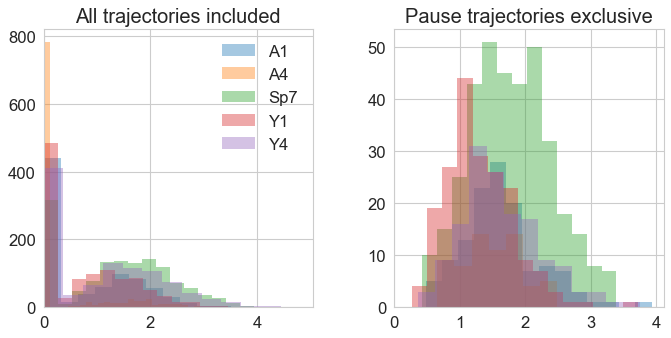

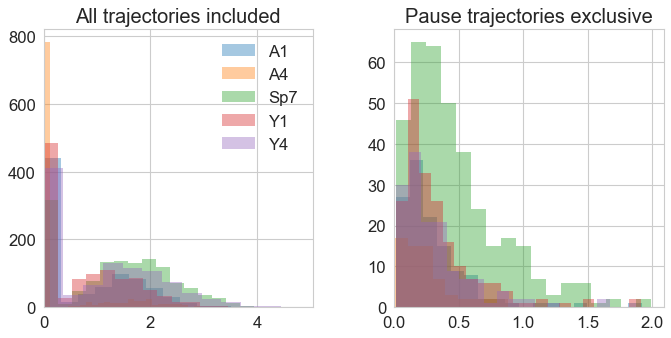

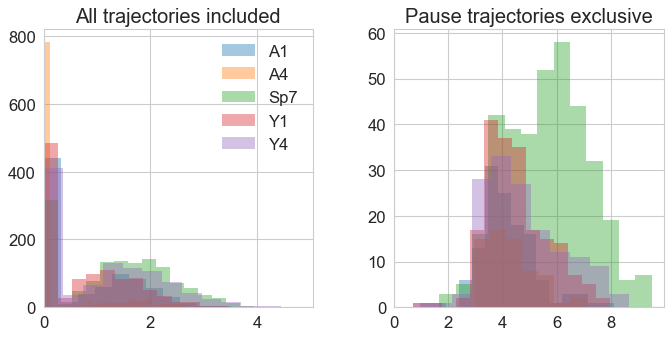

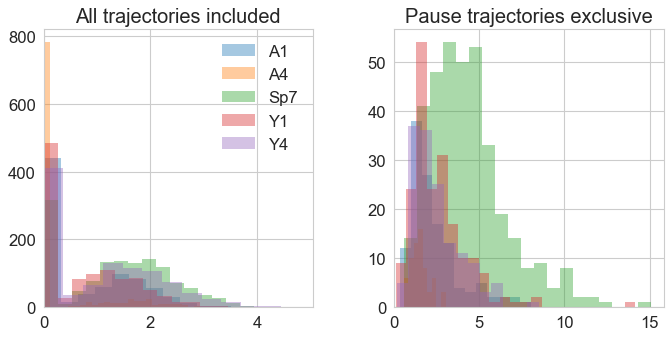

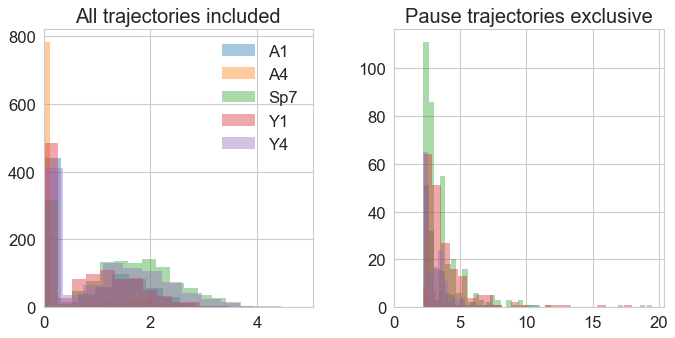

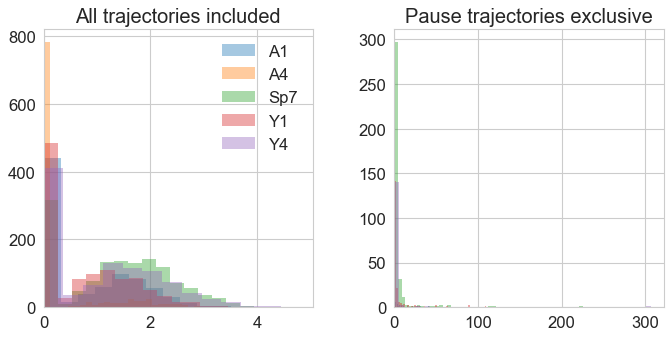

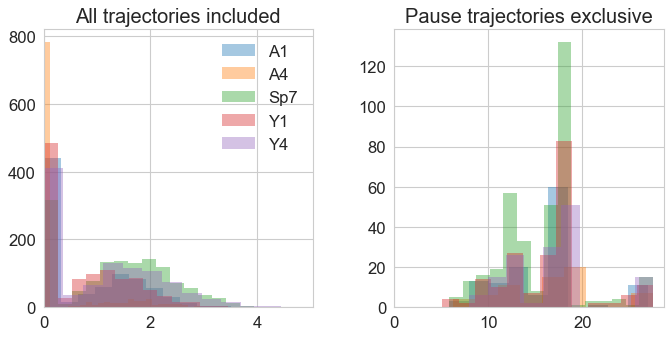

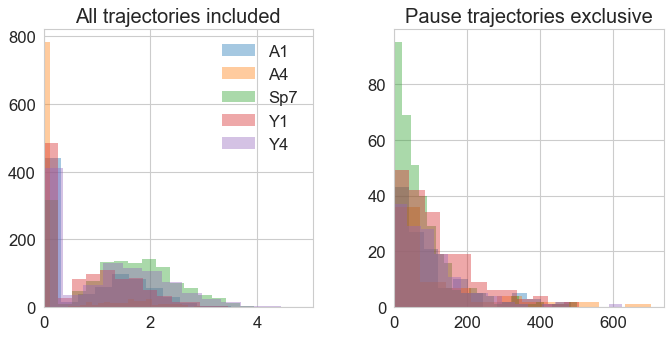

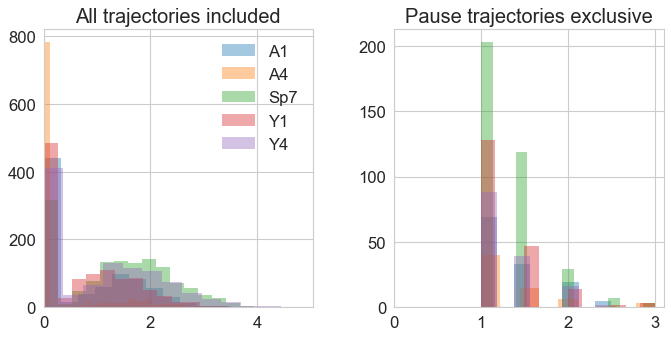

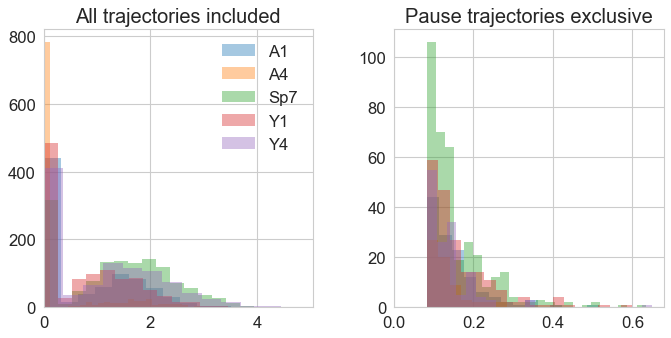

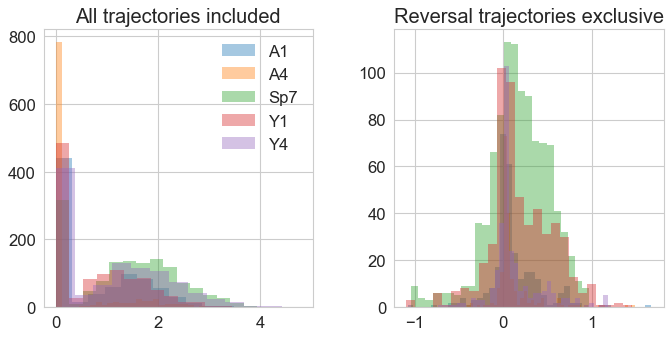

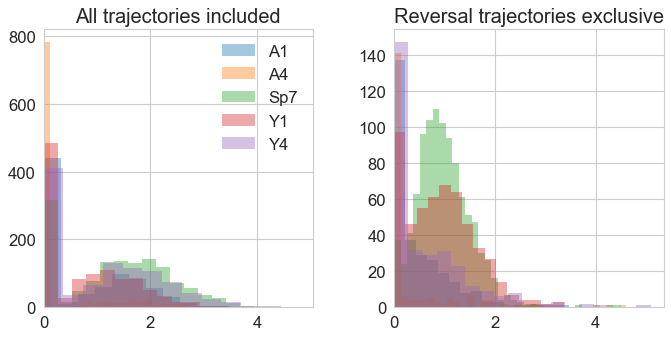

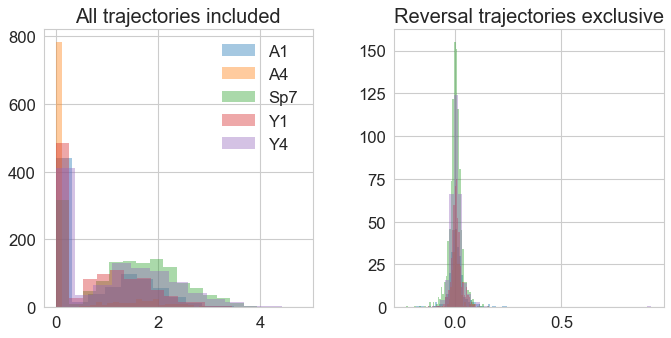

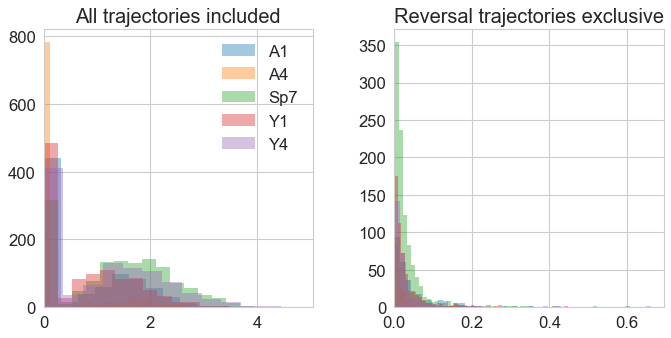

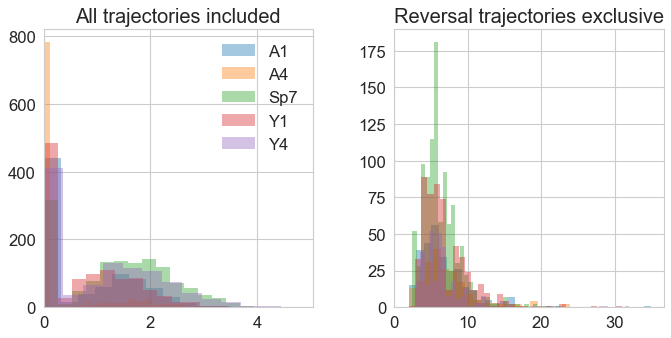

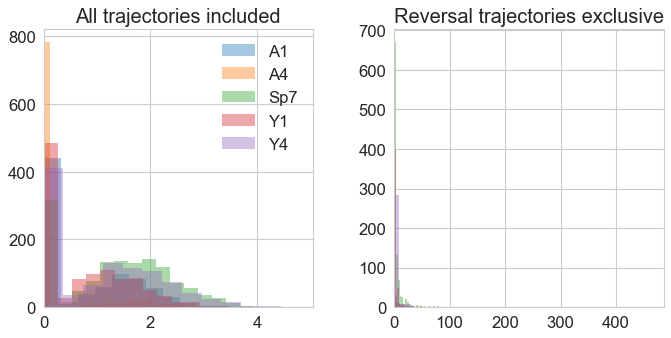

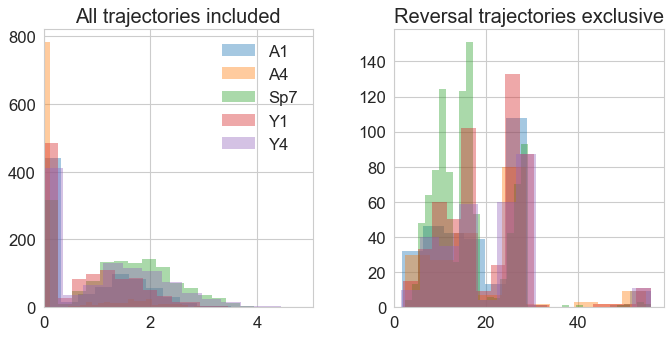

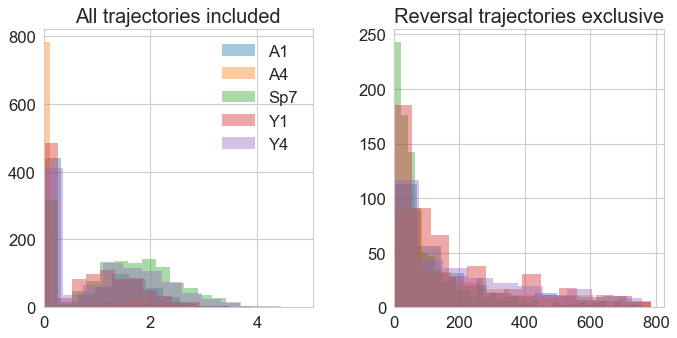

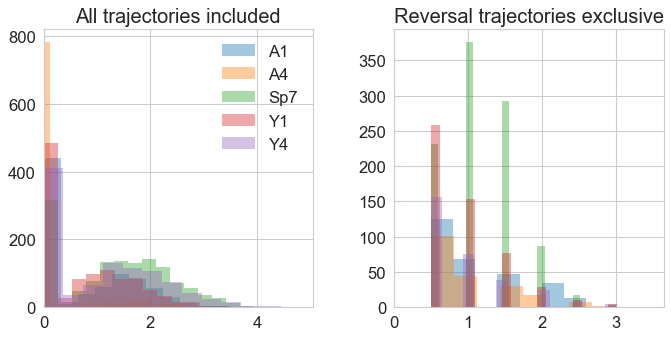

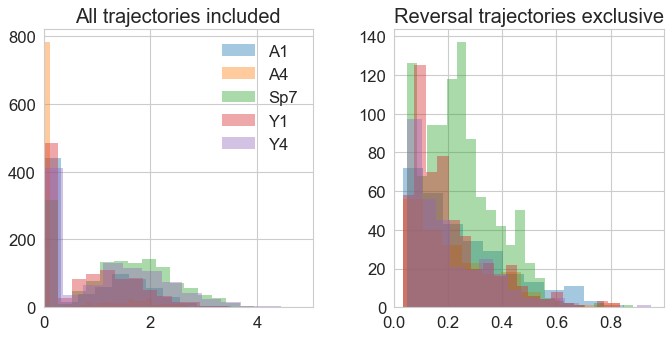

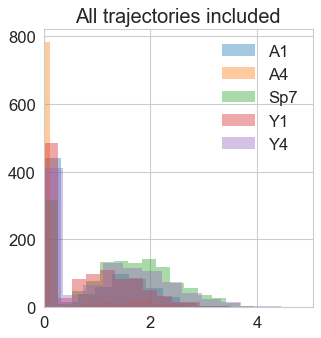

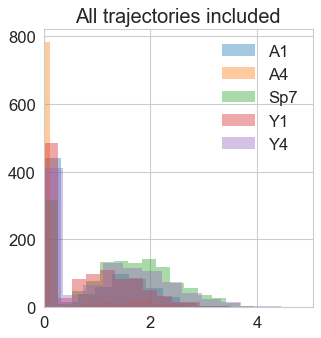

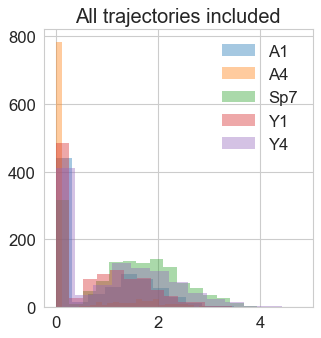

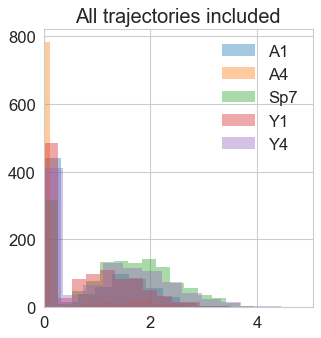

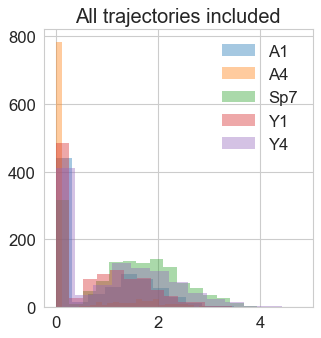

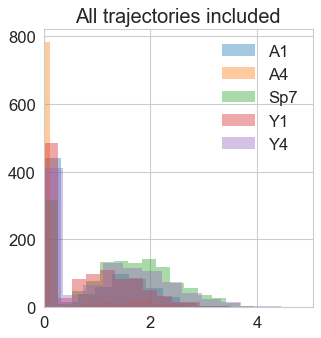

In [398]:
for i in range(26):
    PlotFeatureHist(i)